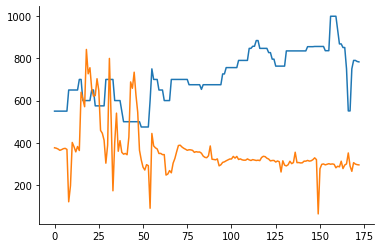

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results

from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor

def regress(x, a, b, c):
    fun = a*x**2 + b*x + c
    return fun

df1 = pd.read_csv('well2.csv')  # bisa sorted or not]
#print(df1.head())


x = df1['GLIR'].values
y = df1['Qt'].values

x_ident = x[:]
y_ident = y[:]

t = np.arange(0,len(x_ident))
plt.plot(t,x_ident)
plt.plot(t,y_ident)



In [2]:
x_train = x_ident.reshape(len(x_ident),1)
y_train = y_ident.reshape(len(y_ident),1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=20,
    ylag=3, xlag=2,
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=x_train, y=y_train)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

       Regressors   Parameters             ERR
0          y(k-1)   2.0885E+00  9.48124825E-01
1   x1(k-1)y(k-3)   6.0552E-04  7.14349135E-03
2   x1(k-1)y(k-1)  -5.2439E-03  1.06243541E-03
3    y(k-3)y(k-2)  -3.9852E-04  2.77818211E-03
4          y(k-3)  -1.3321E+00  1.10367963E-03
5   x1(k-2)y(k-3)   1.5194E-03  1.67286849E-04
6   x1(k-2)y(k-1)   3.1393E-03  8.93066207E-04
7        y(k-3)^2   4.4131E-04  2.72962949E-04
8         x1(k-1)   3.5799E+00  1.76521253E-04
9         x1(k-2)  -3.3298E+00  9.99557862E-04
10      x1(k-1)^2  -1.3709E-03  3.36214972E-04
11      x1(k-2)^2   1.1701E-03  5.87760506E-04


In [3]:
print(np.shape(model.regressor_code))
print(model.theta)

(21, 2)
[[ 2.08846973e+00]
 [ 6.05521746e-04]
 [-5.24388931e-03]
 [-3.98517252e-04]
 [-1.33208054e+00]
 [ 1.51935606e-03]
 [ 3.13933208e-03]
 [ 4.41309315e-04]
 [ 3.57992014e+00]
 [-3.32980980e+00]
 [-1.37087846e-03]
 [ 1.17005295e-03]]


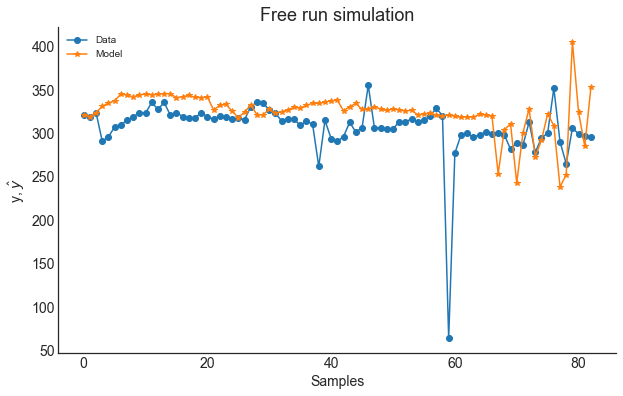

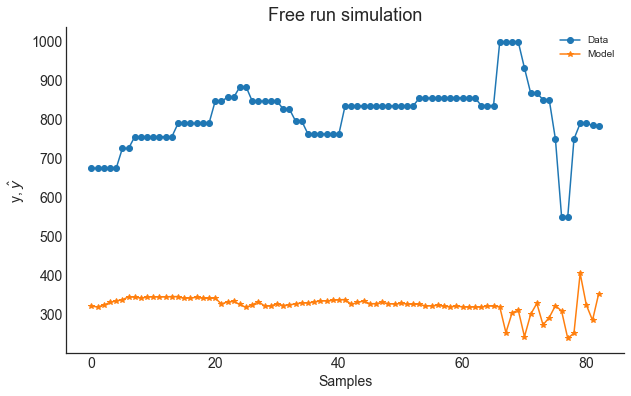

array([353.58377671])

In [4]:
x_valid = x[90:]
y_valid = y[90:]
#yhat = model.predict(X=x_valid,y=y_valid)

solxx = x_valid.reshape(len(x_valid),1)
solyy = y_valid.reshape(len(y_valid),1)

yhat1 = model.predict(X=solxx,y=solyy)
plot_results(y=solyy,yhat=yhat1)
plot_results(y=solxx,yhat=yhat1)

solyy[-1]
yhat1[-1]


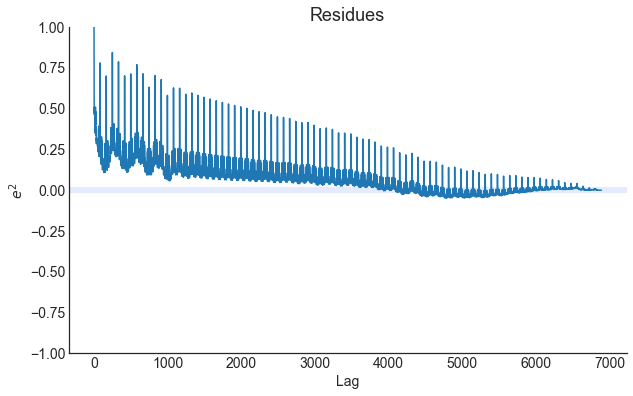

In [5]:
ee = compute_residues_autocorrelation(y_valid, yhat1)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

---Final---
Gain
[[-0.12487508]]
alpha
[[ 0.67619085]
 [-0.11658059]
 [ 0.24153231]]
beta
[[[ 0.10734517]
  [-0.14422356]]]
gamma
[97.25588768]


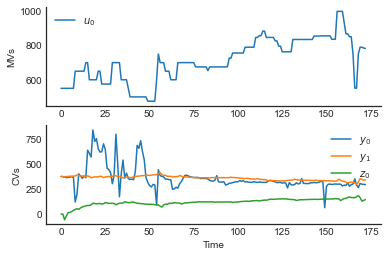

In [6]:
from gekko import GEKKO
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl

# load data and parse into columns
df1 = pd.read_csv('well2.csv')  # bisa sorted or not]
#print(df1.head())

x = df1['GLIR'].values
y = df1['Qt'].values
t = np.arange(0,len(x))

x_ident = x[:]
y_ident = y[:]

# generate time-series model
m = GEKKO(remote=False) # remote=True for MacOS

# system identification
na = 3 # output coefficients
nb = 2 # input coefficients
yp,p,K= m.sysid(t,x_ident,y_ident,na,nb,diaglevel=1,pred='meas')

from scipy.signal import lfilter
den = [-1, p['a'][0][0], p['a'][1][0], p['a'][2][0]]
num = [0.01*97*p['b'][0][0][0], 0.01*97*p['b'][0][1][0]]

xx = x[:]
sys = ctl.tf(num,den,dt=1)
T, ypp = ctl.forced_response(sys, T=t, U=xx ,X0=[0,0,0])

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,x_ident)
plt.legend([r'$u_0$',r'$u_1$'])
plt.ylabel('MVs')

plt.subplot(2,1,2)
plt.plot(t,y_ident)
plt.plot(t,yp)
plt.plot(t,ypp)
plt.legend([r'$y_0$',r'$y_1$',r'$z_0$',r'$z_1$'])
plt.ylabel('CVs')
plt.xlabel('Time')
plt.savefig('sysid.png')
plt.show()

In [7]:
ypp.reshape(len(ypp),1)

array([[  0.        ],
       [  0.        ],
       [-57.26864804],
       [-19.0499152 ],
       [ 13.46965472],
       [ 17.17129898],
       [ 25.11422542],
       [ 37.90814671],
       [ 46.52735488],
       [ 52.78253514],
       [ 48.6850624 ],
       [ 61.25665874],
       [ 71.74597107],
       [ 76.38347194],
       [ 81.33290417],
       [ 86.67253026],
       [ 85.61999444],
       [ 92.47607302],
       [108.93696957],
       [105.02448491],
       [102.11584215],
       [104.58100272],
       [105.64202154],
       [100.16331095],
       [103.92522132],
       [115.17333341],
       [110.52508861],
       [106.97929944],
       [107.84034689],
       [107.71324815],
       [106.67050106],
       [ 93.17259123],
       [101.62340023],
       [108.65949705],
       [109.17185968],
       [110.73918577],
       [123.85119199],
       [118.66875776],
       [114.01439769],
       [114.63830642],
       [119.55731122],
       [119.89798138],
       [112.71073048],
       [108

In [8]:
p['a']
l = p['a'].reshape(len(p['a']),)

p['b']
n = p['b'].reshape(2,)

p['c']

p

{'a': array([[ 0.67619085],
        [-0.11658059],
        [ 0.24153231]]),
 'b': array([[[ 0.10734517],
         [-0.14422356]]]),
 'c': array([97.25588768])}

In [9]:
p['b'][0][1][0]

-0.14422355870180745

In [10]:
den = [1, -p['a'][0][0], -p['a'][1][0], -p['a'][2][0]]
num = [p['b'][0][0][0], p['b'][0][1][0]]

In [11]:
from scipy.signal import lfilter

huhu = x[:]
ypp = lfilter(n,l,huhu)

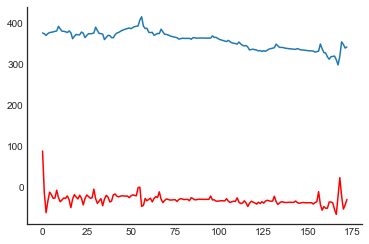

In [12]:
plt.plot(np.arange(0,len(yp)),yp)
plt.plot(np.arange(0,len(ypp)),ypp,'r')

MATLAB Modeling


In [1]:
import control as ctl
import pandas as pd
import numpy as np

df1 = pd.read_csv('well2.csv')  # bisa sorted or not]
#print(df1.head())

x = df1['GLIR'].values
y = df1['Qt'].values

x_ident = x[:]
y_ident = y[:]

#t = np.arange(0,3600*24*len(x_ident),len(x_ident))
t = np.arange(0,3600*24*len(x_ident),3600*24)

#zero delay
num = np.array([0.3678,-0.3667])
den = np.array([1.0000,-1.3745,0.4767,-0.0976])

#orde 2 arx delayed
num = np.array([0.343188420833007,-0.343090293948511,0,0])
den = np.array([1,-1.369332042280427,0.473411287445827,-0.101420313022513]) 

#2nd order delay
#num = np.array([0.343188420833007,-0.343090293948511,0,0])
#den = np.array([1,-1.369332042280427,0.473411287445827,-0.101420313022513])

K = 2.25
K = 1
Ts = 3600*24                                     #1 day sampling day
sys = ctl.TransferFunction(K*num,den, dt=Ts)
print(sys)


      0.7722 z^3 - 0.772 z^2
-----------------------------------
z^3 - 1.369 z^2 + 0.4734 z - 0.1014

dt = 86400



In [2]:
sys

TransferFunction(array([ 0.77217395, -0.77195316,  0.        ,  0.        ]), array([ 1.        , -1.36933204,  0.47341129, -0.10142031]), 86400)

len output = (173,)
len input = (173,)
R2 Score: 0.33934978549425254


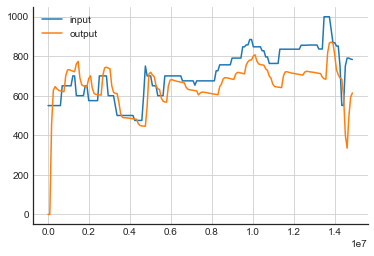

In [92]:
res = ctl.forced_response(sys,T=None,U=x_ident,X0=0)
res.time
y_sys = res.outputs
x_sys = res.inputs

print(f"len output = {np.shape(res.outputs)}")
print(f"len input = {np.shape(res.inputs)}")

import matplotlib.pyplot as plt
plt.plot(t,x_sys, label='input')
plt.plot(t,y_sys, label='output')
plt.grid()
plt.legend()

R = np.corrcoef(x_sys, y_sys, rowvar=False)[0, 1]
R2 = R**2
print(f"R2 Score: {R2}")


In [45]:
#second to day
t_day = 0.5*1e6/(3600*24)
t_day

5.787037037037037

In [93]:
ddf = pd.DataFrame(list(zip(t,x_sys,y_sys)),columns=['t','u','y'])
ddf

,t,u,y
0,0,550,0.000000
1,86400,550,0.000000
2,172800,550,455.152500
3,259200,550,626.968361
4,345600,550,646.158066
...,...,...,...
168,14515200,750,401.901497
169,14601600,790,334.917785
170,14688000,790,493.283500
171,14774400,785,592.546698


BEST Kp Controller


         0.6437 z - 0.6417
-----------------------------------
z^3 - 1.375 z^2 + 0.4767 z - 0.0976

dt = 86400


         0.7356 z - 0.7334
-----------------------------------
z^3 - 1.375 z^2 + 0.4767 z - 0.0976

dt = 86400


         0.8276 z - 0.8251
-----------------------------------
z^3 - 1.375 z^2 + 0.4767 z - 0.0976

dt = 86400



,Kp,R2
0,1.75,0.33935
1,2.00,0.33935
2,2.25,0.33935


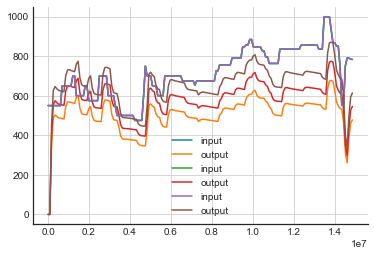

In [86]:
r2_total = []

k = np.arange(1.75,2.5,0.25)
for kp in k:
    df1 = pd.read_csv('well2.csv')  # bisa sorted or not]
    #print(df1.head())

    x = df1['GLIR'].values
    y = df1['Qt'].values

    x_ident = x[:]
    y_ident = y[:]

    #t = np.arange(0,3600*24*len(x_ident),len(x_ident))
    t = np.arange(0,3600*24*len(x_ident),3600*24)

    #zero delay
    num = np.array([0.3678,-0.3667])
    den = np.array([1.0000,-1.3745,0.4767,-0.0976])

    #2nd order delay
    #num = np.array([0.343188420833007,-0.343090293948511,0,0])
    #den = np.array([1,-1.369332042280427,0.473411287445827,-0.101420313022513])

    K = 2.25
    Ts = 3600*24                                     #1 day sampling day
    sys = ctl.TransferFunction(kp*num,den, dt=Ts)
    print(sys)
    res = ctl.forced_response(sys,T=None,U=x_ident,X0=0)
    y_sys = res.outputs
    x_sys = res.inputs

    #print(f"len output = {np.shape(res.outputs)}")
    #print(f"len input = {np.shape(res.inputs)}")

    import matplotlib.pyplot as plt
    plt.plot(t,x_sys, label='input')
    plt.plot(t,y_sys, label='output')
    plt.grid()
    plt.legend()

    R = np.corrcoef(x_sys, y_sys, rowvar=False)[0, 1]
    R2 = R**2
    r2_total.append(R2)
    x_sys = []
    y_sys = []

df_r2 = pd.DataFrame(list(zip(k,r2_total)),columns=['Kp','R2'])
df_r2
    

In [ ]:
class WellDyn():
    def __init__(self, u,i):  # param yg bakal dipake (dataset, )
        self.u = u
        self.i = i

    def WellSys(self,u,i):
        import control as ctl

        #t = np.arange(0,3600*24*len(self.u),3600*24)
        
        if np.shape(self.u) == (1,):
            x_ident = [0,0,self.u[0]]
        elif np.shape(self.u) == (2,):
            x_ident = [0,self.u[0],self.u[1]]
        else:
            x_ident = self.u.iloc[0:i+2]
        
        if np.shape(self.u) == (1,):
            x_dident = [0,0,0]            
        elif np.shape(self.u) == (2,):
            x_dident = [0,0,self.u[0]]
            [0,self.u[0],self.u[1]]
        elif np.shape(self.u) == (3,):
            x_dident = [0,self.u[0],self.u[1]]
        else:
            x_dident = self.u.iloc[]
        
        #u_sys = x_ident - x_dident

        #zero delay
        num = np.array([0.3678,-0.3667])
        den = np.array([1.0000,-1.3745,0.4767,-0.0976])

        #second order delay
        num = np.array([0.343188420833007,-0.343090293948511,0,0])
        den = np.array([1,-1.369332042280427,0.473411287445827,-0.101420313022513])

        K = 1.5
        #K = 1
        Ts = 3600*24  #1 day sampling day
        sys = ctl.TransferFunction(K*num,den, dt=Ts)

        res = ctl.forced_response(sys,T=None,U=x_ident,X0=0)
        y_sys = res.outputs
        x_sys = res.inputs
        
        return y_sys